In [162]:
import matplotlib.pyplot as plt
import numpy as np
import numba
from random import choices, expovariate
@numba.njit()
def weighted_prob(arr,p,s=1):
    #assuming sum(p)==1
    return arr[np.searchsorted(np.cumsum(p),np.random.random()*s,side='right')]
import xml.etree.ElementTree as ET
from collections import OrderedDict as odict
import numpy as np
import re


#compounds,changes,stoichs,rates,v_assoc,rv_assoc=parseVCML('SF_testing1.vcml')
#rates=adjust_constants(rates,stoichs,rv_assoc)
#print(rates)
#compounds['Deg_GFPmRNA']=100
#print(compounds.keys())

from numba import int32, float32, float64 , int64   # import the types
from numba.experimental import jitclass
cell_spec=[
    ('species',float64[:]),
    ('changes',float64[:,:]),
    ('stoichs',float64[:,:]),
    ('rates',float64[:]),
    ('assoc_v',float64[:])
]
@jitclass(cell_spec)
class ICell:
    def __init__(self, species, changes,stoichs,rates,assoc_v):
        self.species=species
        self.changes=changes
        self.stoichs=stoichs
        self.rates=rates
        self.assoc_v=assoc_v
from tqdm import tqdm
import multiprocessing as mp
import time
#@numba.njit()

@numba.njit()
def stacked_multicellular2(cells,shared_idx,timestep,t0,tend):
    #assumed shared_idx is the same across all cells 
    #assuming all cells are the same 
    #shared species will go at the front of the new species array and be taken out of their normal spots for each cell 
    #laws and stoichs will have their shared_idx removed and transferred to the start
    startTime=time.time()
    print('start')
    ts=np.arange(t0,tend,timestep)
    record=np.ones(shape=(len(cells),len(ts),cells[0].species.shape[0]))
    #nonshared=np.arange(len(cells[0].species))[~np.isin(np.arange(len(cells[0].species)),shared_idx)]
    nonshared=np.array([i for i in range(len(cells[0].species)) if i not in shared_idx])
    steps=(tend-t0)//timestep
    nshared=len(shared_idx)
    totalSpecies=nshared+len(cells)*(len(cells[0].species)-nshared)#sum(len(cell.species)-nshared for cell in cells)
    totalRxns=len(cells[0].changes)*len(cells)#sum(len(cell.changes) for cell in cells)
    allSpecies=np.empty(totalSpecies)
    print('allocated species')
    allLaws=np.zeros(shape=(totalRxns,totalSpecies))
    allRates=np.empty(shape=totalRxns)
    allChanges=np.zeros(shape=(totalRxns,totalSpecies))
    sidx=nshared
    ridx=0
    allSpecies[:sidx]=cells[0].species[shared_idx]
    #print(allSpecies.shape,allLaws.shape,allChanges.shape,record.shape)
    #print(nonshared)
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        #print('ridx',ridx,ridx+cellRxns.shape[0])
        nextSidx=sidx+len(nonshared)
        #print('sidx',sidx,nextSidx)
        #print(len(nonshared),cellSpecies[nonshared])
        allSpecies[sidx:nextSidx]=cellSpecies[nonshared]
        
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.stoichs[:,nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],:nshared]=cell.stoichs[:,shared_idx]
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.changes[:,nonshared]
        allChanges[ridx:ridx+cellRxns.shape[0],:nshared]=cell.changes[:,shared_idx]
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        #allSharedIdx[cellCount*len(shared_idx):(cellCount+1)*len(shared_idx)]=shared_idx+sidx
        sidx=nextSidx
        ridx+=cellRxns.shape[0]
    print(allSpecies)
    print(allLaws[0])
    print(allChanges)
    #print('r',allRates)
    #return
    tcount=0
    #for i in tqdm(range(len(ts))):
    for i in range(len(ts)):
        while tcount<timestep:
            ds,dt=numbaGillespieStep(allSpecies,allChanges,allLaws,allRates)
            #ds,dt=gillespieStepBetter(allSpecies,allChanges,allLaws,allRates)
            tcount+=dt
            allSpecies+=ds
        tcount=0
        #print(allSpecies)
        for j in range(len(cells)):
            nspecies=len(cells[j].species)
            #print('afasdfsd',allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)])
            record[j,i,nshared:]=allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)]
        record[:,:,:nshared]=allSpecies[:nshared]
    endTime=time.time()
    print('done with sim in', startTime/endTime)
    return ts,record

@numba.njit()
def gillespieStepWithIndex(species, changes, law_coeffs,law_idxs,rates):
    #law_idxs=[np.argwhere(row>0).reshape(-1) for row in laws]
    #law_coeffs=[row[i,law_idxs] for i in range(len(laws))]
    propensities=np.empty(changes.shape[0],np.float64)
    for i in range(len(propensities)):
        propensities[i]=np.prod(species[law_idxs[i]]**law_coeffs[i])
    propensities*=rates
    summed=propensities.sum()
    action=weighted_prob(changes,p=propensities,s=summed)
    dt=expovariate(summed)
    return action,dt

def gillespieStepWithIndexFixed(species, changes, law_coeffs,law_idxs,rates):
    #law_idxs=[np.argwhere(row>0).reshape(-1) for row in laws]
    #law_coeffs=[row[i,law_idxs] for i in range(len(laws))]
    propensities=np.ones(changes.shape[0],np.float64)
    for i in range(len(propensities)):
        idxs=law_idxs[i]
        start=1
        for j in range(len(idxs)):
            idx=idxs[j]
            if idx==-1:
                propensities[i]=0
                break
            coeff=law_coeffs[i,idx]
            for k in range(coeff):
                start*=(species[idx]-k)
        propensities[i]=start
        #propensities[i]=np.prod(species[law_idxs[i]]**law_coeffs[i])
    propensities*=rates
    summed=propensities.sum()
    action=weighted_prob(changes,p=propensities,s=summed)
    dt=expovariate(summed)
    return action,dt
@numba.njit(parallel=True)
def stacked_multicellular_idx_based(cells,shared_idx,timestep,t0,tend,maxSteps=float('inf')):
    #assumed shared_idx is the same across all cells 
    #assuming all cells are the same 
    #shared species will go at the front of the new species array and be taken out of their normal spots for each cell 
    #laws and stoichs will have their shared_idx removed and transferred to the start
    ts=np.arange(t0,tend,timestep)
    record=np.ones(shape=(len(cells),len(ts),cells[0].species.shape[0]))
    nonshared=np.array([i for i in range(len(cells[0].species)) if i not in shared_idx])
    steps=(tend-t0)//timestep
    nshared=len(shared_idx)
    totalSpecies=nshared+len(cells)*(len(cells[0].species)-nshared)
    totalRxns=len(cells[0].changes)*len(cells)
    allSpecies=np.empty(totalSpecies)
    allLaws=np.zeros(shape=(totalRxns,totalSpecies))
    allRates=np.empty(shape=totalRxns)
    allChanges=np.zeros(shape=(totalRxns,totalSpecies))
    sidx=nshared
    ridx=0
    allSpecies[:sidx]=cells[0].species[shared_idx]
    for cell in cells:
        cellSpecies=cell.species
        cellRxns=cell.changes
        nextSidx=sidx+len(nonshared)
        allSpecies[sidx:nextSidx]=cellSpecies[nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.stoichs[:,nonshared]
        allLaws[ridx:ridx+cellRxns.shape[0],:nshared]=cell.stoichs[:,shared_idx]
        allChanges[ridx:ridx+cellRxns.shape[0],sidx:nextSidx]=cell.changes[:,nonshared]
        allChanges[ridx:ridx+cellRxns.shape[0],:nshared]=cell.changes[:,shared_idx]
        allRates[ridx:ridx+cellRxns.shape[0]]=cell.rates
        sidx=nextSidx
        ridx+=cellRxns.shape[0]
    allLawIdxs=[np.argwhere(allLaws[i]).flatten() for i in range(len(allLaws))]
    allLawCoeffs=[allLaws[i,allLawIdxs[i]] for i in range(len(allLaws))]
    tcount=0
    steps=0
    t=0
    for i in range(len(ts)):
        while t//timestep<i+1:
            ds,dt=gillespieStepWithIndex(allSpecies,allChanges,allLawCoeffs,allLawIdxs,allRates)
            tcount+=dt
            t+=dt
            allSpecies+=ds
            steps+=1
            if steps>maxSteps:
                print('max steps exceeded')
                return ts[:i],record[:,:i,:]
            #print(f'i={i}, t={t}, tcount={tcount}, increment={t//timestep}')
        tcount=0
        for j in range(len(cells)):
            nspecies=len(cells[j].species)
            record[j,i,nshared:]=allSpecies[nshared+j*len(nonshared):nshared+(j+1)*len(nonshared)]
        record[:,i,:nshared]=allSpecies[:nshared]
    #print("done with sim in",steps,"steps, about", float(steps/len(ts)),"/",timestep," or ",float(steps/timestep),"/second")
    return ts,record
def clampSpecies(changes,idx):
    a=changes.copy()
    a[idx]=0
    return a
def makeReplicate(nCells,species,changes,stoichs,rates, shared_idx,timestep,t0,tend, numReplicate=10):
    #runs simulations many times 
    #returns times and 4d array of records of shape [trial number, cell number, time number, species]
    #take mean per cell record[:,:, -1 , speciesIdx].mean(1)
    ts=np.arange(t0,tend,timestep)
    allRecord=np.empty((numReplicate,nCells,len(ts),len(species)),np.float64)
    populations=[[ICell(species.copy(),changes.copy(),stoichs.copy(),rates.copy(),np.ones(len(stoichs),np.float64)) 
                  for i in range(nCells)] for j in range(numReplicate)]
    for i in tqdm(range(numReplicate)):
    #for i in numba.prange(numReplicate):
    #for i in range(numReplicate):
        cells=populations[i]
        _,trialRecord=stacked_multicellular_idx_based(cells,shared_idx,timestep,t0,tend)
        allRecord[i,:,:,:]=trialRecord
    print('done')
    return ts,allRecord


'''
TF+DNA=>TF.DNA
TF.DNA=>TF+DNA
TF.DNA=>mRNA_TF+TF.DNA
mRNA_TF=>null
mRNA_TF=>TF+P
TF=>TF_out
TF_out=>TF
TF=>null
P=>null
~~
A_out=>A
A=>A_out
A+DNA=>A.DNA
A.DNA=>A+DNA
A.DNA=>TF
[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
'''
TFchanges=np.array([
    [0,-1,-1,1,0,0,0],
    [0,1,1,-1,0,0,0],
    [0,0,0,0,1,0,0],
    [0,0,0,0,-1,1,0],
    [0,1,0,0,0,0,1],
    [1,-1,0,0,0,0,0],
    [-1,1,0,0,0,0,0],
    [0,-1,0,0,0,1,0],
    [0,0,0,0,0.,1,-1]
])
nCells=100
tfRates=np.array([.01,1,.1,.05,1,1,.01,.1,.1])
tfLaws=(TFchanges==-1).astype(float)
tfLaws[2,3]=1
tfLaws[4,4]=1
t0=np.array([3000.,0,100,0,0,0,0])
seqCells100=[ICell(t0.copy(),TFchanges.astype(float),tfLaws.astype(float),tfRates.astype(float),np.ones(len(TFchanges)).astype(float)) for i in range(100)]
#seq_ts100,seq_concs100=stacked_multicellular2(seqCells100,np.array([0]),.01,0,20)#about 7 minute runtime
#seq_ts100,seq_concs100=stacked_multicellular_idx_based(seqCells100,np.array([0]),.01,0,20)#about 1 minute run time, 5 sec with numba (20 second simulation)
#seq_ts100,seq_concs100=multicellular3(seqCells100,np.array([0]),.01,0,20)#mega slow


In [99]:
def doAnalysis(ts,cell_concs,idx=-1):
    plt.plot(ts,cell_concs[:,:,:,idx].mean(0).T,alpha=0.4,color='gray')
    plt.plot(ts,cell_concs[:,:,:,idx].mean(0).mean(0).T)
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count Per Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.show()
    plt.plot(ts,cell_concs[0,:,:,idx].T)
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count In a Single Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.show()
    print('mean overall P concentration')
    print(cell_concs[:,:,-1,idx].mean())
    print('aggregate overall P concentration')
    print(cell_concs[:,:,-1,idx].mean(0).sum())
    print('mean concentrations per trial')
    printVert(cell_concs[:,:,-1,idx].mean(1))
    print('mean aggregate P production')
    printVert(cell_concs[:,:,-1,idx].sum(1))
    return 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]


done


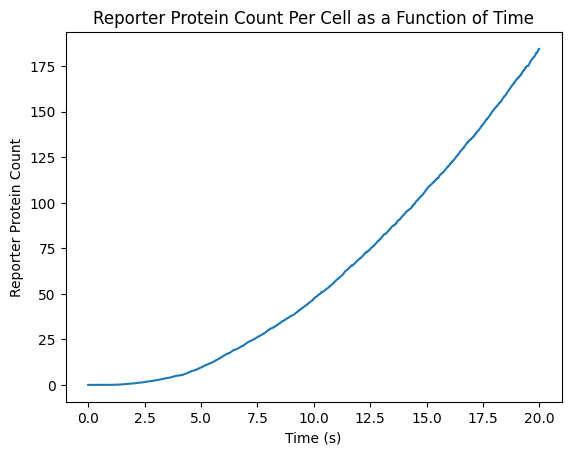

mean overall P concentration
184.5
aggregate overall P concentration
184.5
mean concentrations per trial
153.0
203.0
166.0
150.0
173.0
125.0
162.0
116.0
206.0
207.0
96.0
197.0
262.0
199.0
257.0
146.0
217.0
241.0
341.0
207.0
135.0
216.0
220.0
176.0
154.0
211.0
160.0
143.0
238.0
146.0
164.0
178.0
197.0
247.0
109.0
125.0
190.0
130.0
162.0
205.0
204.0
117.0
213.0
199.0
188.0
180.0
185.0
198.0
203.0
208.0
mean aggregate P production
153.0
203.0
166.0
150.0
173.0
125.0
162.0
116.0
206.0
207.0
96.0
197.0
262.0
199.0
257.0
146.0
217.0
241.0
341.0
207.0
135.0
216.0
220.0
176.0
154.0
211.0
160.0
143.0
238.0
146.0
164.0
178.0
197.0
247.0
109.0
125.0
190.0
130.0
162.0
205.0
204.0
117.0
213.0
199.0
188.0
180.0
185.0
198.0
203.0
208.0


In [42]:
def printVert(l):
    for i in l:
        print(i)
ts1,cell_concs1=makeReplicate(1,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts1,cell_concs1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.13s/it]

done


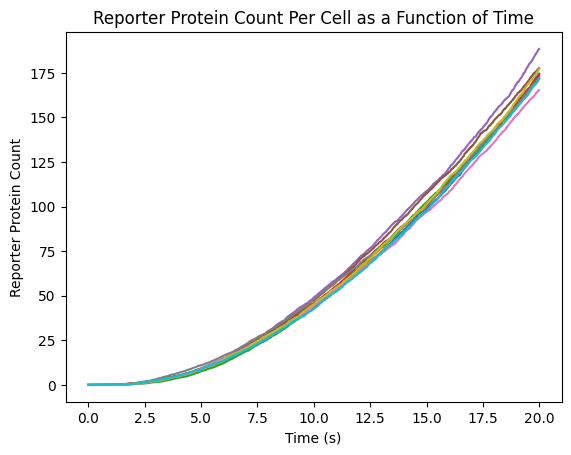

mean overall P concentration
174.568
aggregate overall P concentration
1745.6799999999998
mean concentrations per trial
168.2
180.9
202.5
157.9
144.1
167.9
179.9
169.9
183.9
198.2
183.2
160.1
155.0
173.6
181.6
166.9
168.2
172.7
186.2
176.0
179.3
169.3
166.8
191.8
159.2
193.9
167.5
162.5
182.9
165.3
187.6
174.3
183.1
157.1
172.3
174.4
171.3
190.7
184.4
161.8
152.8
196.6
191.7
169.0
175.8
191.1
175.2
175.9
158.3
169.6
mean aggregate P production
1682.0
1809.0
2025.0
1579.0
1441.0
1679.0
1799.0
1699.0
1839.0
1982.0
1832.0
1601.0
1550.0
1736.0
1816.0
1669.0
1682.0
1727.0
1862.0
1760.0
1793.0
1693.0
1668.0
1918.0
1592.0
1939.0
1675.0
1625.0
1829.0
1653.0
1876.0
1743.0
1831.0
1571.0
1723.0
1744.0
1713.0
1907.0
1844.0
1618.0
1528.0
1966.0
1917.0
1690.0
1758.0
1911.0
1752.0
1759.0
1583.0
1696.0


In [41]:
ts10,cell_concs10=makeReplicate(10,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts10,cell_concs10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:16<00:00,  6.33s/it]

done


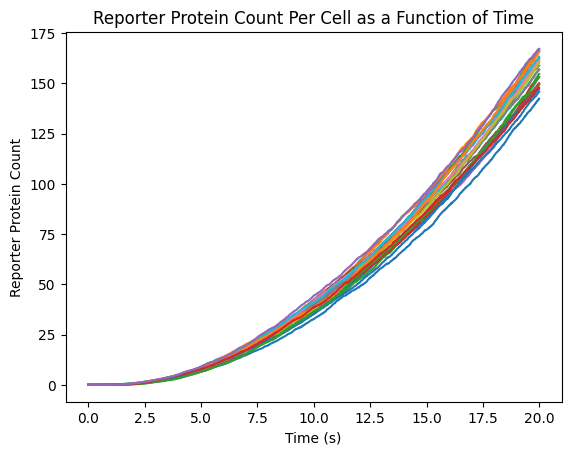

mean overall P concentration
157.2712
aggregate overall P concentration
3931.78
mean concentrations per trial
145.88
175.12
141.16
163.32
150.36
159.68
156.12
137.48
174.88
148.32
158.24
158.96
153.84
151.8
159.72
167.72
159.8
159.4
165.96
155.56
151.12
154.96
164.84
157.68
162.8
157.56
162.36
147.52
164.04
156.88
152.88
168.56
164.8
148.12
146.32
163.04
142.4
161.08
158.12
162.28
143.52
144.36
154.48
154.88
162.2
160.88
152.6
175.28
164.84
159.84
mean aggregate P production
3647.0
4378.0
3529.0
4083.0
3759.0
3992.0
3903.0
3437.0
4372.0
3708.0
3956.0
3974.0
3846.0
3795.0
3993.0
4193.0
3995.0
3985.0
4149.0
3889.0
3778.0
3874.0
4121.0
3942.0
4070.0
3939.0
4059.0
3688.0
4101.0
3922.0
3822.0
4214.0
4120.0
3703.0
3658.0
4076.0
3560.0
4027.0
3953.0
4057.0
3588.0
3609.0
3862.0
3872.0
4055.0
4022.0
3815.0
4382.0
4121.0
3996.0


In [36]:
ts25,cell_concs25=makeReplicate(25,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts25,cell_concs25)

In [ ]:
ts50,cell_concs50=makeReplicate(50,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)


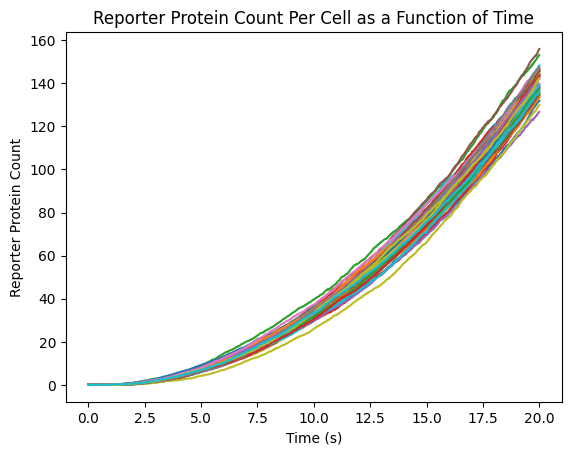

mean overall P concentration
141.164
aggregate overall P concentration
7058.200000000001
mean concentrations per trial
144.1
150.72
135.52
133.18
143.7
138.36
143.08
156.76
130.54
135.1
129.94
145.04
141.7
137.24
140.36
140.64
141.5
128.82
152.94
151.7
137.2
137.3
138.62
144.12
129.26
149.02
144.32
141.1
152.2
141.74
143.0
135.22
134.54
138.6
147.0
147.16
141.78
134.76
146.3
150.64
139.04
144.56
137.88
142.3
138.02
151.3
134.2
142.24
138.92
134.92
mean aggregate P production
7205.0
7536.0
6776.0
6659.0
7185.0
6918.0
7154.0
7838.0
6527.0
6755.0
6497.0
7252.0
7085.0
6862.0
7018.0
7032.0
7075.0
6441.0
7647.0
7585.0
6860.0
6865.0
6931.0
7206.0
6463.0
7451.0
7216.0
7055.0
7610.0
7087.0
7150.0
6761.0
6727.0
6930.0
7350.0
7358.0
7089.0
6738.0
7315.0
7532.0
6952.0
7228.0
6894.0
7115.0
6901.0
7565.0
6710.0
7112.0
6946.0
6746.0


In [39]:
doAnalysis(ts50,cell_concs50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:47<00:00, 20.14s/it]


done


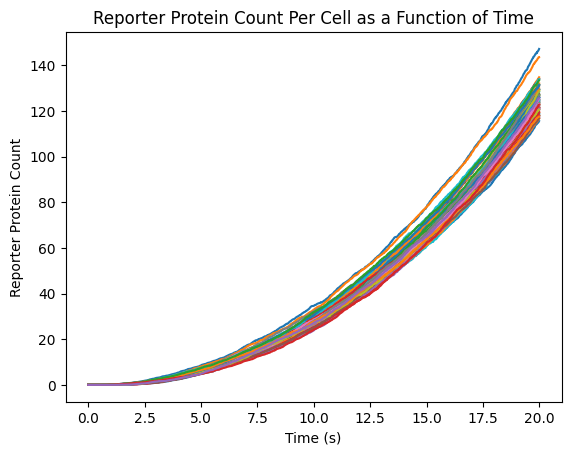

mean overall P concentration
125.2104
aggregate overall P concentration
9390.779999999999
mean concentrations per trial
137.72
112.48
129.52
127.8
127.06666666666666
122.69333333333333
126.62666666666667
124.54666666666667
123.33333333333333
131.38666666666666
125.37333333333333
121.37333333333333
121.97333333333333
126.21333333333334
132.52
125.68
117.78666666666666
126.29333333333334
124.70666666666666
133.2
117.08
120.33333333333333
128.21333333333334
117.93333333333334
117.52
120.82666666666667
120.98666666666666
124.81333333333333
123.05333333333333
121.06666666666666
127.06666666666666
126.90666666666667
119.54666666666667
127.8
133.58666666666667
127.74666666666667
125.0
129.42666666666668
127.05333333333333
128.74666666666667
133.22666666666666
121.8
125.53333333333333
119.18666666666667
121.32
132.08
127.29333333333334
119.90666666666667
126.30666666666667
130.86666666666667
mean aggregate P production
10329.0
8436.0
9714.0
9585.0
9530.0
9202.0
9497.0
9341.0
9250.0
9854.0
9403

In [40]:
ts75,cell_concs75=makeReplicate(75,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts75,cell_concs75)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [24:05<00:00, 28.91s/it]


done


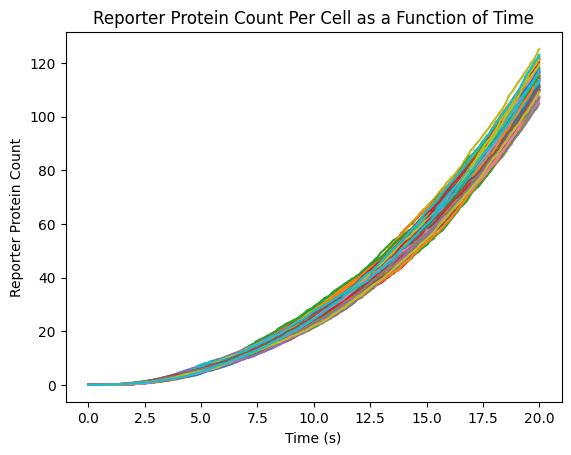

mean overall P concentration
114.3064
aggregate overall P concentration
11430.64
mean concentrations per trial
116.92
119.24
113.34
113.23
104.48
118.17
113.72
116.21
114.37
112.97
125.33
117.33
115.87
120.83
116.3
110.18
120.54
118.21
110.96
105.76
107.6
114.64
110.74
114.75
119.11
106.2
116.06
117.01
112.98
121.98
113.38
115.66
122.17
116.94
110.32
107.07
108.54
112.38
106.79
120.19
106.2
114.2
119.32
118.28
119.22
108.24
120.64
114.28
107.99
108.48
mean aggregate P production
11692.0
11924.0
11334.0
11323.0
10448.0
11817.0
11372.0
11621.0
11437.0
11297.0
12533.0
11733.0
11587.0
12083.0
11630.0
11018.0
12054.0
11821.0
11096.0
10576.0
10760.0
11464.0
11074.0
11475.0
11911.0
10620.0
11606.0
11701.0
11298.0
12198.0
11338.0
11566.0
12217.0
11694.0
11032.0
10707.0
10854.0
11238.0
10679.0
12019.0
10620.0
11420.0
11932.0
11828.0
11922.0
10824.0
12064.0
11428.0
10799.0
10848.0


In [37]:
ts100,cell_concs100=makeReplicate(100,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts100,cell_concs100)

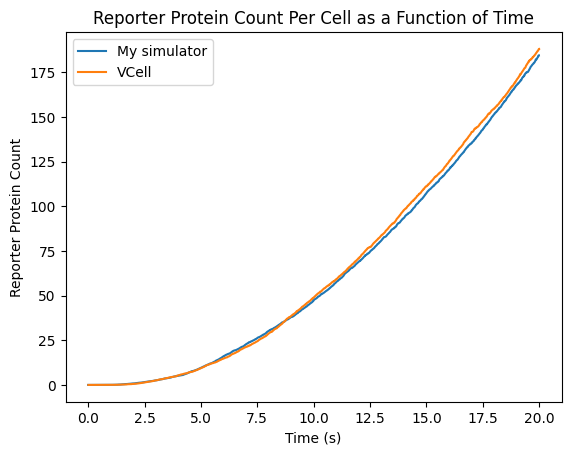

In [58]:
importedVcell=np.loadtxt("vcell_1cell.tsv",delimiter='\t').reshape(-1,2)
fig_vcell,ax_vcell=plt.subplots()
ax_vcell.set_xlabel("Time (s)")
ax_vcell.set_title("Reporter Protein Count Per Cell as a Function of Time")
ax_vcell.set_ylabel("Reporter Protein Count")

ax_vcell.plot(ts1,cell_concs1[:,0,:,-1].mean(0),label="My simulator")
ax_vcell.plot(importedVcell[1:,0],importedVcell[1:,1],label="VCell")
ax_vcell.legend()
plt.show()

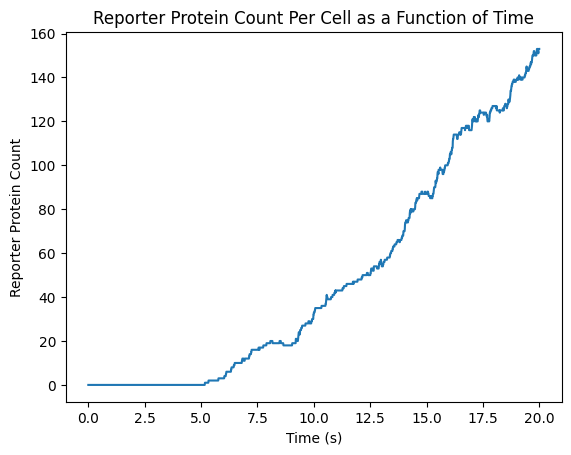

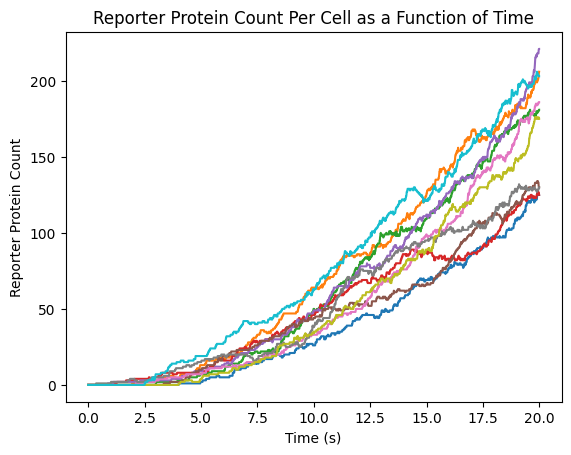

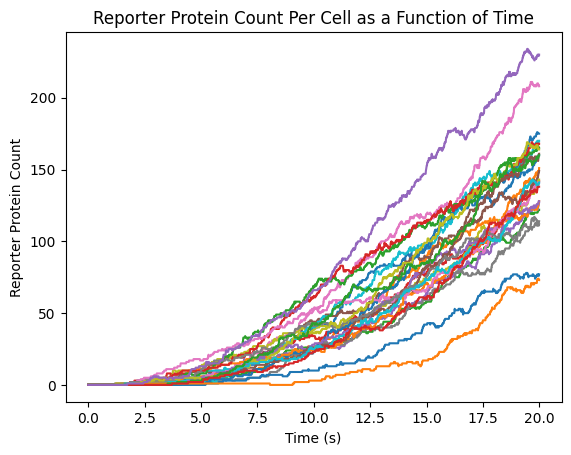

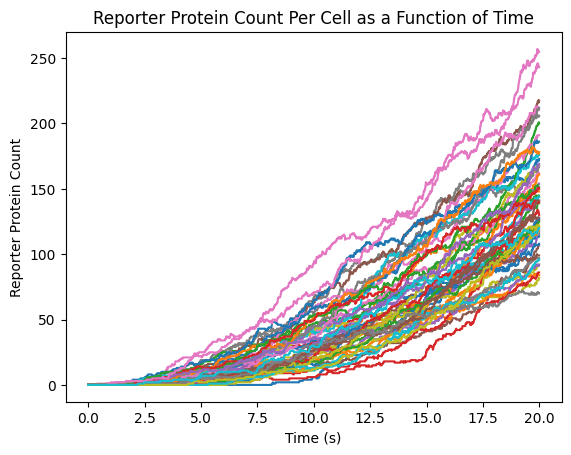

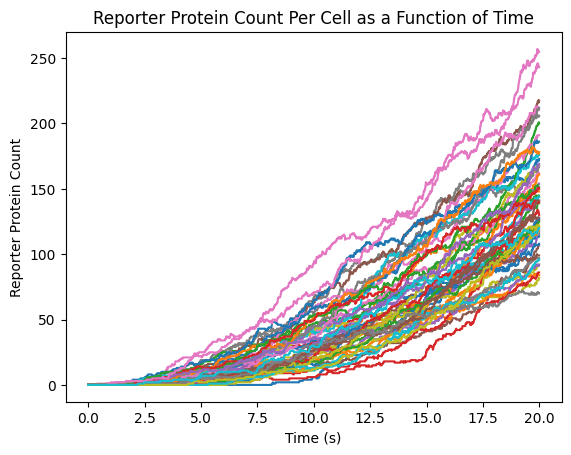

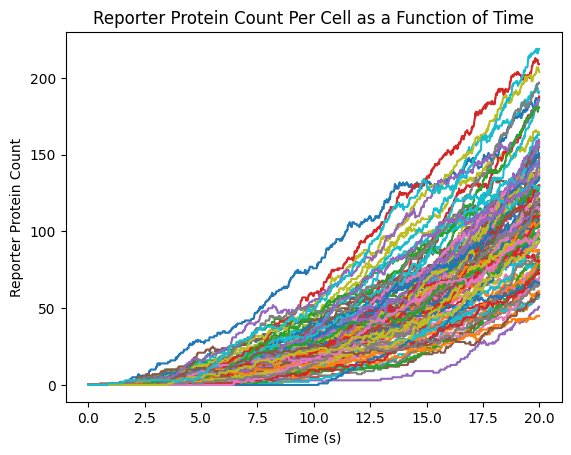

In [49]:
def singleSample(ts,concs):
    plt.plot(ts,concs[0,:,:,-1].T)
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count Per Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.show()
for cc in (cell_concs1,cell_concs10,cell_concs25,cell_concs50,cell_concs50,cell_concs100):
    singleSample(ts1,cc)

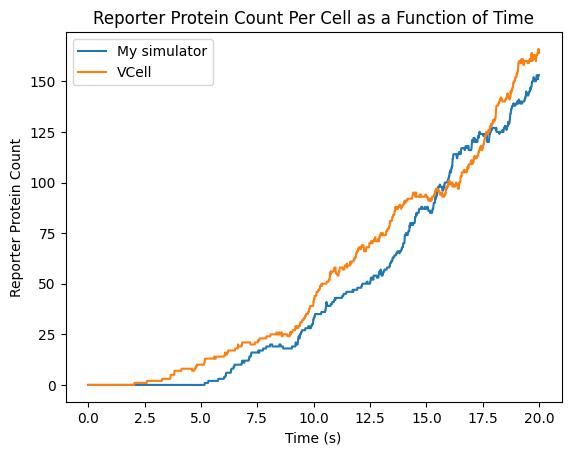

In [61]:
importedVcellSingle=np.loadtxt("vcell_1cell_single.tsv",delimiter='\t').reshape(-1,2)
fig_vcell,ax_vcells=plt.subplots()
ax_vcells.set_xlabel("Time (s)")
ax_vcells.set_title("Reporter Protein Count Per Cell as a Function of Time")
ax_vcells.set_ylabel("Reporter Protein Count")

ax_vcells.plot(ts1,cell_concs1[0,0,:,-1],label="My simulator")
ax_vcells.plot(importedVcell[1:,0],importedVcellSingle[1:,1],label="VCell")
ax_vcells.legend()
plt.show()

In [65]:
from sklearn.metrics import r2_score
r2_score(importedVcell[1:,1],cell_concs1[:,0,:,-1].mean(0))

0.9978378373877009

In [64]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 801.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 5.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 4.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 10.3 MB/s eta 0:00:0000:0100:01


In [68]:
cell_concs1.tofile("regionals-data/cell_concs1")
cell_concs10.tofile("regionals-data/cell_concs10")
cell_concs25.tofile("regionals-data/cell_concs25")
cell_concs50.tofile("regionals-data/cell_concs50")
cell_concs75.tofile("regionals-data/cell_concs75")
cell_concs100.tofile("regionals-data/cell_concs100")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [3:22:31<00:00, 243.03s/it]


done


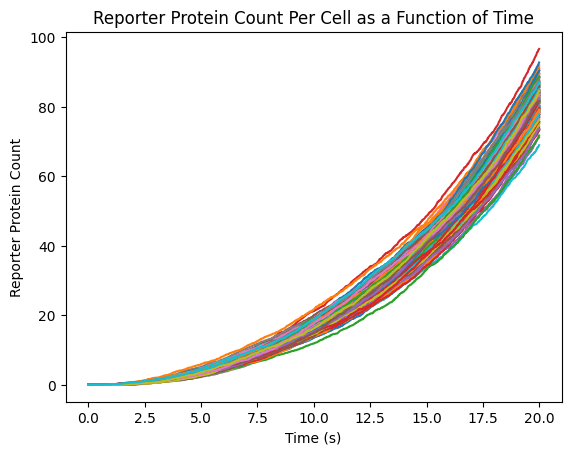

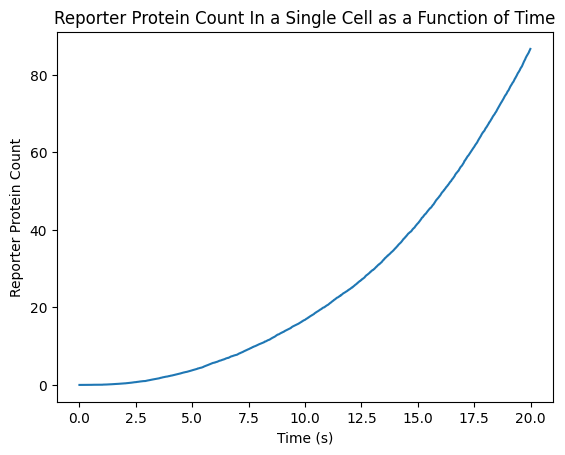

mean overall P concentration
82.312
aggregate overall P concentration
16462.4
mean concentrations per trial
86.735
81.94
90.355
80.8
80.085
79.035
84.57
86.365
85.485
84.11
81.2
83.48
80.485
77.08
85.4
85.695
79.245
82.825
77.525
88.96
79.75
81.245
81.255
78.105
84.78
77.02
79.785
85.26
84.3
83.145
82.895
79.655
81.39
88.12
78.03
85.25
82.81
84.11
82.435
78.96
80.01
81.35
80.59
80.025
78.895
81.965
81.65
83.93
79.805
87.705
mean aggregate P production
17347.0
16388.0
18071.0
16160.0
16017.0
15807.0
16914.0
17273.0
17097.0
16822.0
16240.0
16696.0
16097.0
15416.0
17080.0
17139.0
15849.0
16565.0
15505.0
17792.0
15950.0
16249.0
16251.0
15621.0
16956.0
15404.0
15957.0
17052.0
16860.0
16629.0
16579.0
15931.0
16278.0
17624.0
15606.0
17050.0
16562.0
16822.0
16487.0
15792.0
16002.0
16270.0
16118.0
16005.0
15779.0
16393.0
16330.0
16786.0
15961.0
17541.0


In [69]:
ts200,cell_concs200=makeReplicate(200,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,20,50)
doAnalysis(ts200,cell_concs200)

In [70]:
ts25_50s,cell_concs25_50s=makeReplicate(25,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)
doAnalysis(ts25_50s,cell_concs25_50s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [47:29<00:00, 57.00s/it]

done


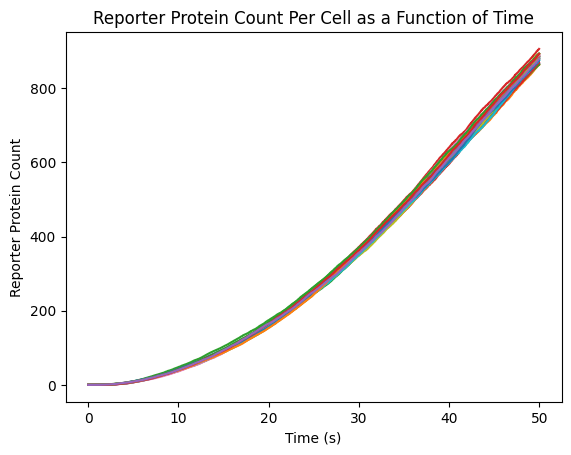

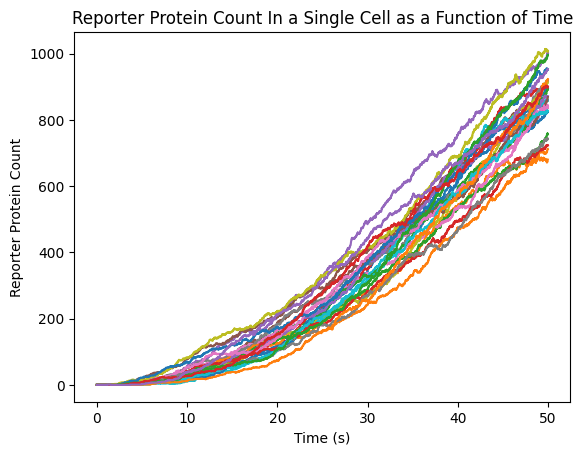

mean overall P concentration
881.6648
aggregate overall P concentration
22041.620000000003
mean concentrations per trial
866.8
928.36
912.36
876.84
862.04
938.84
827.56
905.92
846.8
861.64
873.84
913.4
832.76
921.36
868.6
887.0
867.04
889.84
885.12
907.12
826.56
850.16
881.6
856.4
881.24
872.28
862.52
939.24
899.2
950.84
881.0
937.0
870.36
902.0
837.2
889.72
870.4
866.96
876.48
896.92
879.12
825.96
867.88
925.4
910.8
848.88
867.24
871.16
885.2
880.28
mean aggregate P production
21670.0
23209.0
22809.0
21921.0
21551.0
23471.0
20689.0
22648.0
21170.0
21541.0
21846.0
22835.0
20819.0
23034.0
21715.0
22175.0
21676.0
22246.0
22128.0
22678.0
20664.0
21254.0
22040.0
21410.0
22031.0
21807.0
21563.0
23481.0
22480.0
23771.0
22025.0
23425.0
21759.0
22550.0
20930.0
22243.0
21760.0
21674.0
21912.0
22423.0
21978.0
20649.0
21697.0
23135.0
22770.0
21222.0
21681.0
21779.0
22130.0
22007.0


In [75]:
doAnalysis(ts25_50s,cell_concs25_50s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]

done


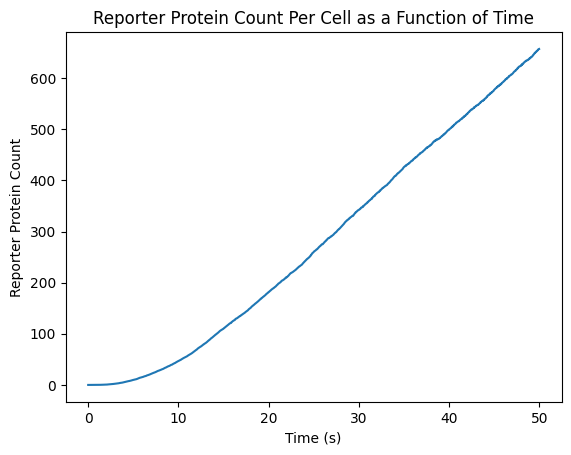

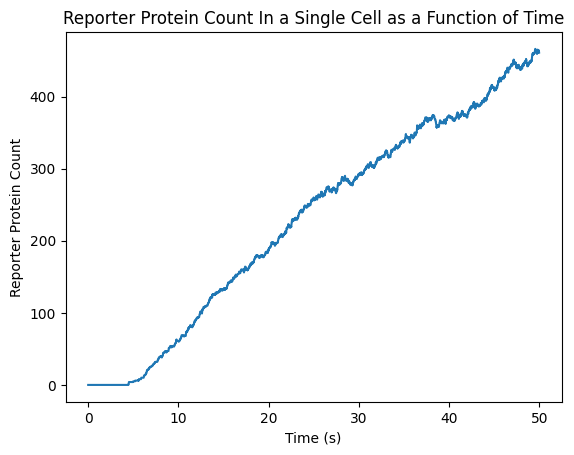

mean overall P concentration
657.04
aggregate overall P concentration
657.04
mean concentrations per trial
461.0
845.0
651.0
810.0
557.0
514.0
788.0
532.0
736.0
568.0
845.0
607.0
571.0
644.0
611.0
606.0
694.0
594.0
676.0
732.0
620.0
659.0
643.0
632.0
818.0
748.0
479.0
483.0
789.0
684.0
452.0
419.0
726.0
586.0
655.0
697.0
717.0
662.0
647.0
688.0
669.0
541.0
586.0
820.0
871.0
785.0
800.0
622.0
713.0
599.0
mean aggregate P production
461.0
845.0
651.0
810.0
557.0
514.0
788.0
532.0
736.0
568.0
845.0
607.0
571.0
644.0
611.0
606.0
694.0
594.0
676.0
732.0
620.0
659.0
643.0
632.0
818.0
748.0
479.0
483.0
789.0
684.0
452.0
419.0
726.0
586.0
655.0
697.0
717.0
662.0
647.0
688.0
669.0
541.0
586.0
820.0
871.0
785.0
800.0
622.0
713.0
599.0


In [74]:
ts1_50s,cell_concs1_50s=makeReplicate(1,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)
doAnalysis(ts1_50s,cell_concs1_50s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:51<00:00, 13.04s/it]


done


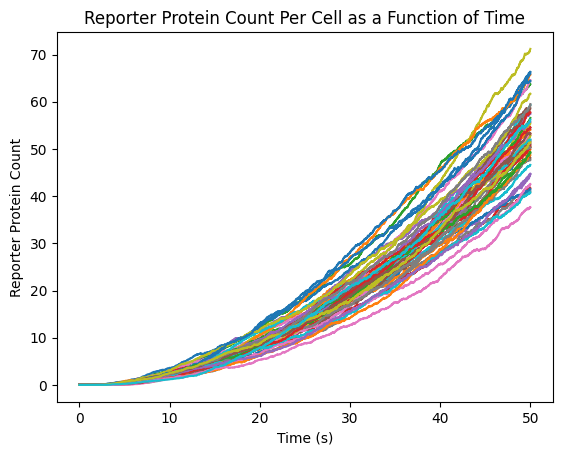

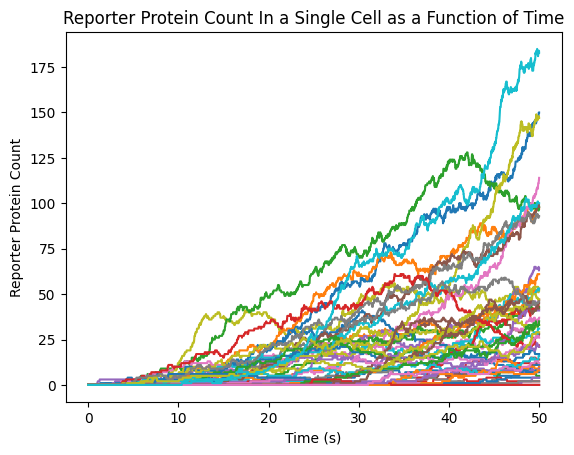

mean overall P concentration
53.1904
aggregate overall P concentration
2659.5199999999995
mean concentrations per trial
42.0
47.12
47.24
63.06
56.36
48.26
43.8
42.38
67.36
57.9
67.82
65.74
56.56
60.98
43.58
51.22
59.42
44.74
43.86
55.9
52.38
63.52
48.44
57.04
55.02
49.16
57.34
52.2
46.82
52.8
55.72
51.12
52.68
53.58
61.96
65.5
61.32
56.26
47.16
51.32
40.56
40.9
68.08
53.24
70.14
40.86
48.94
46.7
42.36
51.1
mean aggregate P production
2100.0
2356.0
2362.0
3153.0
2818.0
2413.0
2190.0
2119.0
3368.0
2895.0
3391.0
3287.0
2828.0
3049.0
2179.0
2561.0
2971.0
2237.0
2193.0
2795.0
2619.0
3176.0
2422.0
2852.0
2751.0
2458.0
2867.0
2610.0
2341.0
2640.0
2786.0
2556.0
2634.0
2679.0
3098.0
3275.0
3066.0
2813.0
2358.0
2566.0
2028.0
2045.0
3404.0
2662.0
3507.0
2043.0
2447.0
2335.0
2118.0
2555.0


In [83]:
'''
TF+DNA=>TF.DNA
TF.DNA=>TF+DNA
TF.DNA=>mRNA_TF+TF.DNA
mRNA_TF=>null
mRNA_TF=>TF+P
TF=>TF_out
TF_out=>TF
TF=>null
P=>null
[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
'''
test_ts,test_concs=makeReplicate(50,np.array([1e6,0,100,0,0,0,0]),TFchanges,tfLaws,np.array([.01,1,.1,.05,1,1,1e-6,.1,.1]),np.array([0]),
                              .01,0,50,50)
doAnalysis(test_ts,test_concs)

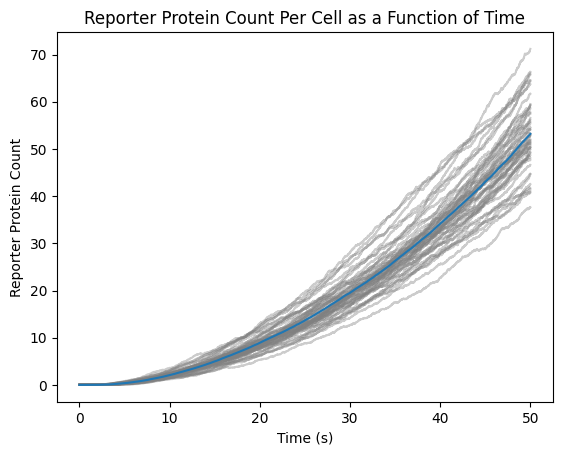

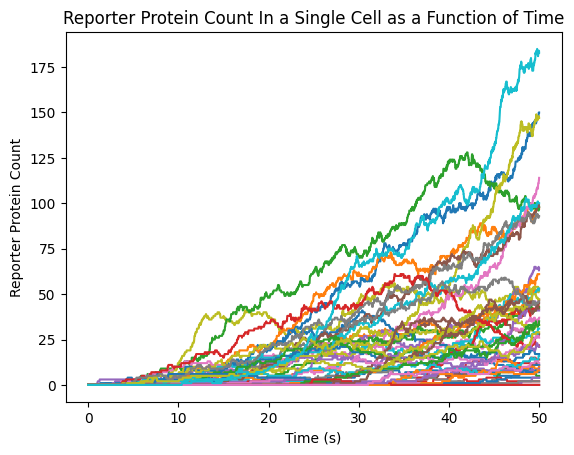

mean overall P concentration
53.1904
aggregate overall P concentration
2659.5199999999995
mean concentrations per trial
42.0
47.12
47.24
63.06
56.36
48.26
43.8
42.38
67.36
57.9
67.82
65.74
56.56
60.98
43.58
51.22
59.42
44.74
43.86
55.9
52.38
63.52
48.44
57.04
55.02
49.16
57.34
52.2
46.82
52.8
55.72
51.12
52.68
53.58
61.96
65.5
61.32
56.26
47.16
51.32
40.56
40.9
68.08
53.24
70.14
40.86
48.94
46.7
42.36
51.1
mean aggregate P production
2100.0
2356.0
2362.0
3153.0
2818.0
2413.0
2190.0
2119.0
3368.0
2895.0
3391.0
3287.0
2828.0
3049.0
2179.0
2561.0
2971.0
2237.0
2193.0
2795.0
2619.0
3176.0
2422.0
2852.0
2751.0
2458.0
2867.0
2610.0
2341.0
2640.0
2786.0
2556.0
2634.0
2679.0
3098.0
3275.0
3066.0
2813.0
2358.0
2566.0
2028.0
2045.0
3404.0
2662.0
3507.0
2043.0
2447.0
2335.0
2118.0
2555.0


In [100]:
doAnalysis(test_ts,test_concs,-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]

done


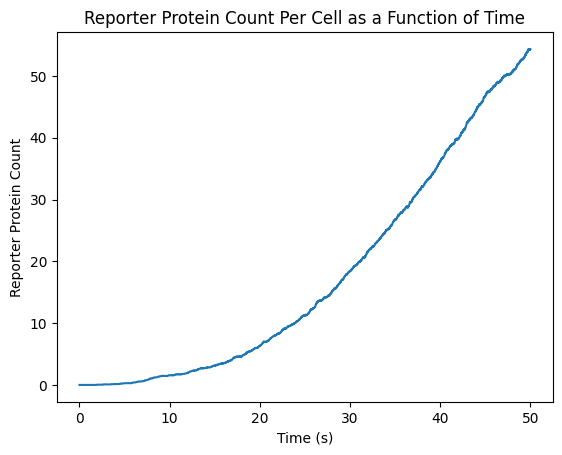

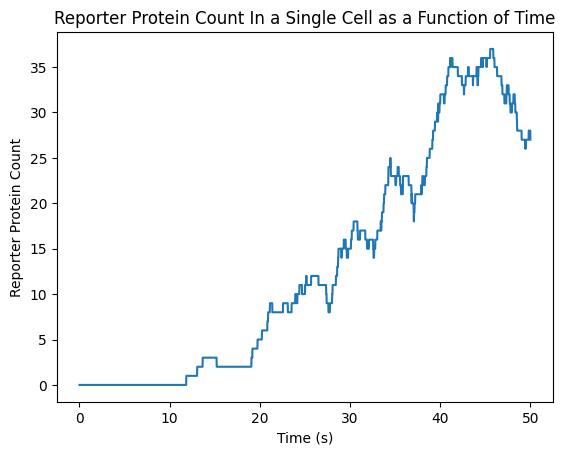

mean overall P concentration
54.32
aggregate overall P concentration
54.32
mean concentrations per trial
27.0
27.0
28.0
82.0
66.0
14.0
79.0
49.0
59.0
36.0
46.0
72.0
58.0
88.0
49.0
127.0
17.0
9.0
50.0
13.0
36.0
89.0
13.0
76.0
51.0
0.0
192.0
51.0
47.0
45.0
112.0
30.0
201.0
71.0
0.0
39.0
13.0
2.0
17.0
50.0
37.0
216.0
0.0
23.0
56.0
31.0
37.0
19.0
155.0
11.0
mean aggregate P production
27.0
27.0
28.0
82.0
66.0
14.0
79.0
49.0
59.0
36.0
46.0
72.0
58.0
88.0
49.0
127.0
17.0
9.0
50.0
13.0
36.0
89.0
13.0
76.0
51.0
0.0
192.0
51.0
47.0
45.0
112.0
30.0
201.0
71.0
0.0
39.0
13.0
2.0
17.0
50.0
37.0
216.0
0.0
23.0
56.0
31.0
37.0
19.0
155.0
11.0


In [87]:
test_ts1,test_concs1=makeReplicate(1,np.array([1e6,0,100,0,0,0,0]),TFchanges,tfLaws,np.array([.01,1,.1,.05,1,1,1e-6,.1,.1]),np.array([0]),
                              .01,0,50,50)
doAnalysis(test_ts1,test_concs1)

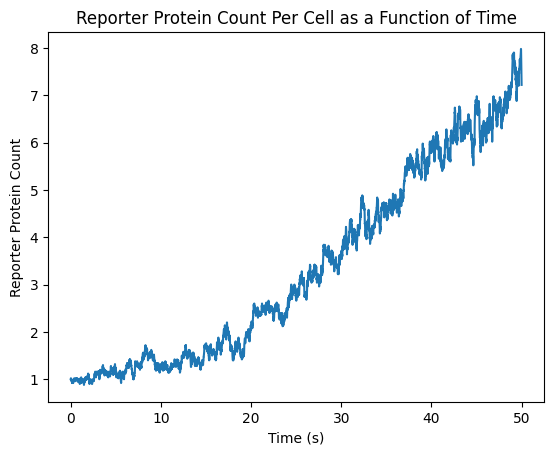

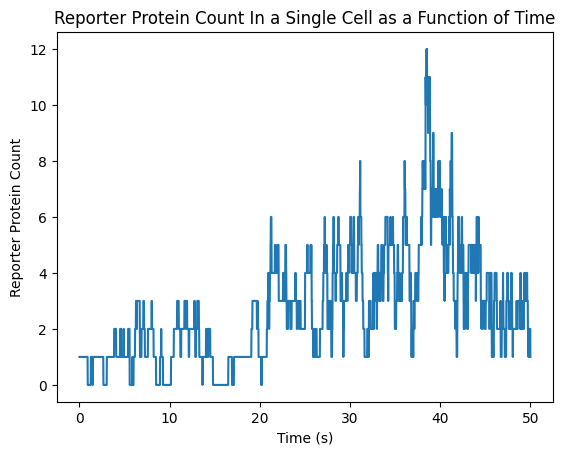

mean overall P concentration
7.22
aggregate overall P concentration
7.22
mean concentrations per trial
1.0
9.0
6.0
15.0
9.0
2.0
9.0
3.0
7.0
3.0
7.0
12.0
3.0
10.0
8.0
17.0
5.0
3.0
6.0
5.0
4.0
7.0
3.0
16.0
8.0
1.0
19.0
4.0
5.0
5.0
14.0
0.0
25.0
12.0
1.0
7.0
3.0
2.0
2.0
8.0
8.0
27.0
1.0
4.0
8.0
1.0
2.0
5.0
17.0
2.0
mean aggregate P production
1.0
9.0
6.0
15.0
9.0
2.0
9.0
3.0
7.0
3.0
7.0
12.0
3.0
10.0
8.0
17.0
5.0
3.0
6.0
5.0
4.0
7.0
3.0
16.0
8.0
1.0
19.0
4.0
5.0
5.0
14.0
0.0
25.0
12.0
1.0
7.0
3.0
2.0
2.0
8.0
8.0
27.0
1.0
4.0
8.0
1.0
2.0
5.0
17.0
2.0


In [92]:
doAnalysis(test_ts1,test_concs1,1)

In [101]:
ts100_50s,cell_concs100_50s=makeReplicate(100,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)
ts50_50s,cell_concs50_50s=makeReplicate(50,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [4:36:03<00:00, 331.26s/it]


done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:29:37<00:00, 107.56s/it]

done


In [102]:
ts75_50s,cell_concs75_50s=makeReplicate(75,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [4:03:43<00:00, 292.47s/it]

done


In [103]:
ts25_50s,cell_concs25_50s=makeReplicate(25,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:41:15<00:00, 193.51s/it]

done


In [104]:
ts10_50s,cell_concs10_50s=makeReplicate(10,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:43<00:00, 10.48s/it]

done


In [105]:
ts1_50s,cell_concs1_50s=makeReplicate(1,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s]

done


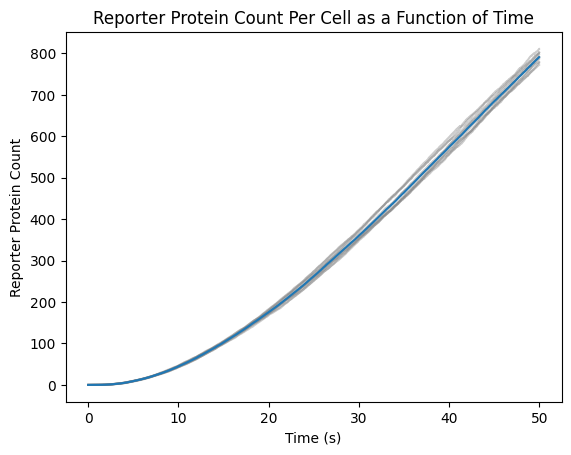

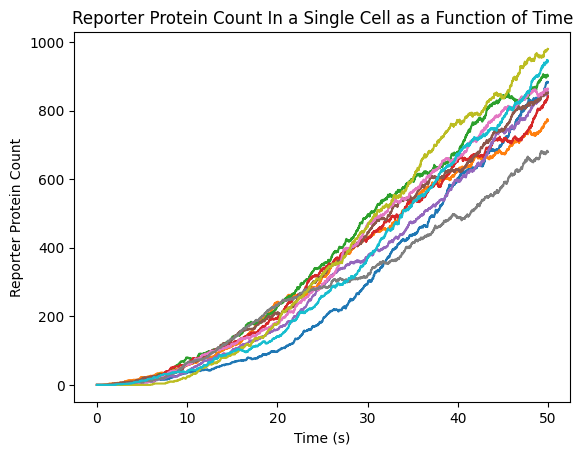

mean overall P concentration
791.196
aggregate overall P concentration
7911.96
mean concentrations per trial
856.8
845.1
777.5
750.9
828.0
742.1
756.9
771.4
746.7
798.6
835.5
753.8
812.5
769.0
800.6
827.8
828.5
770.5
756.1
803.6
797.9
852.8
768.7
781.1
820.8
814.2
769.8
824.2
754.8
790.5
749.4
755.0
814.8
830.9
819.2
829.5
762.0
806.6
747.9
733.3
868.6
810.1
831.6
769.8
756.3
757.1
789.4
740.2
769.9
811.5
mean aggregate P production
8568.0
8451.0
7775.0
7509.0
8280.0
7421.0
7569.0
7714.0
7467.0
7986.0
8355.0
7538.0
8125.0
7690.0
8006.0
8278.0
8285.0
7705.0
7561.0
8036.0
7979.0
8528.0
7687.0
7811.0
8208.0
8142.0
7698.0
8242.0
7548.0
7905.0
7494.0
7550.0
8148.0
8309.0
8192.0
8295.0
7620.0
8066.0
7479.0
7333.0
8686.0
8101.0
8316.0
7698.0
7563.0
7571.0
7894.0
7402.0
7699.0
8115.0


In [109]:
doAnalysis(ts10_50s,cell_concs10_50s)

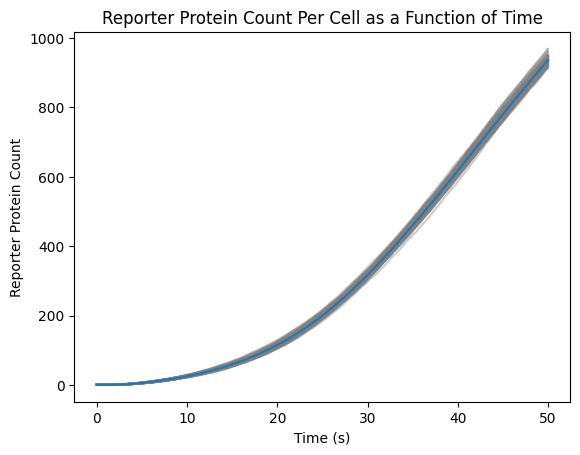

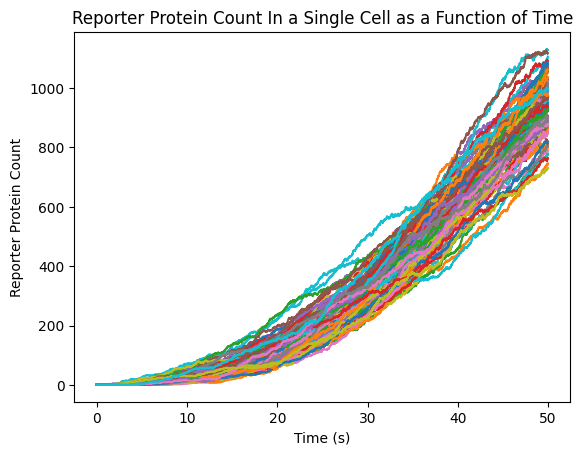

mean overall P concentration
935.995
aggregate overall P concentration
93599.5
mean concentrations per trial
930.56
916.96
914.99
946.04
943.06
911.51
938.16
936.12
927.24
919.11
919.11
919.54
919.73
951.37
920.59
929.37
928.81
961.88
921.21
937.87
940.16
960.98
930.97
931.41
951.19
954.4
952.84
925.83
970.16
982.32
944.55
917.43
944.88
937.19
955.44
942.94
942.04
927.37
941.69
947.17
931.07
944.76
936.88
915.93
924.0
917.2
939.68
938.4
925.93
931.71
mean aggregate P production
93056.0
91696.0
91499.0
94604.0
94306.0
91151.0
93816.0
93612.0
92724.0
91911.0
91911.0
91954.0
91973.0
95137.0
92059.0
92937.0
92881.0
96188.0
92121.0
93787.0
94016.0
96098.0
93097.0
93141.0
95119.0
95440.0
95284.0
92583.0
97016.0
98232.0
94455.0
91743.0
94488.0
93719.0
95544.0
94294.0
94204.0
92737.0
94169.0
94717.0
93107.0
94476.0
93688.0
91593.0
92400.0
91720.0
93968.0
93840.0
92593.0
93171.0


In [113]:
doAnalysis(ts100_50s,cell_concs100_50s)

In [115]:
*237.6/254.5

1.0711279461279462

In [116]:
import math
math.e**(237.6/254.5)

2.54363786039723

In [119]:
!ls

BioModel1.vcml         kinetics2.ipynb        save_1cell
SF_testing1.vcml       optimization.ipynb     save_50cell
ibw_vagrant            regionals-data         scripting.ipynb
ibw_vagrant.zip        save_100cell           vcell_1cell.tsv
kinetics.ipynb         save_10cell            vcell_1cell_single.tsv


In [120]:
cell_concs100_50s.tofile('cell_concs100_50s')

In [123]:
cell_concs50_50s.tofile('cell_concs50_50s')
cell_concs75_50s.tofile('cell_concs75_50s')
cell_concs25_50s.tofile('cell_concs25_50s')
cell_concs10_50s.tofile('cell_concs10_50s')
cell_concs1_50s.tofile('cell_concs1_50s')

In [125]:
tryImport=np.fromfile('cell_concs50_50s').reshape(50, 50, 5000, 7)

True

In [127]:
ts150_50s,cell_concs150_50s=makeReplicate(150,t0,TFchanges,tfLaws,tfRates,np.array([0]),
                              .01,0,50,50)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [9:21:40<00:00, 674.01s/it]

done


In [128]:
cell_concs150_50s.tofile('cell_concs150_50s')

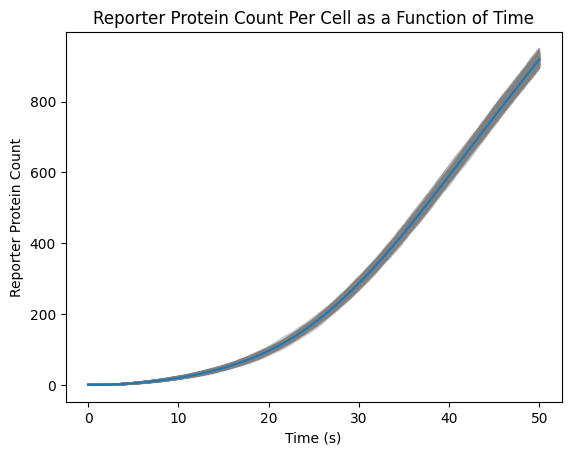

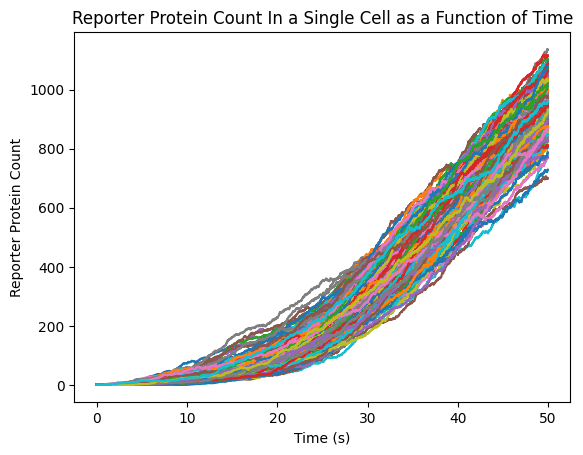

mean overall P concentration
918.288
aggregate overall P concentration
137743.2
mean concentrations per trial
943.5266666666666
905.5
939.7933333333333
918.98
879.34
900.9133333333333
918.66
906.1133333333333
948.0933333333334
899.8
917.0733333333334
912.98
930.38
926.88
893.92
904.9466666666667
914.9466666666667
916.84
891.92
911.7533333333333
904.86
920.2266666666667
932.2933333333333
915.5466666666666
913.0733333333334
909.2733333333333
893.6533333333333
937.56
924.6266666666667
929.1066666666667
938.0
931.88
912.0733333333334
922.2733333333333
924.56
921.9466666666667
928.52
925.66
931.0066666666667
933.6866666666666
924.8266666666667
907.7533333333333
926.1933333333334
924.12
908.9733333333334
896.9733333333334
939.1533333333333
915.4266666666666
916.7866666666666
922.0066666666667
mean aggregate P production
141529.0
135825.0
140969.0
137847.0
131901.0
135137.0
137799.0
135917.0
142214.0
134970.0
137561.0
136947.0
139557.0
139032.0
134088.0
135742.0
137242.0
137526.0
133788.0
136

In [129]:
doAnalysis(ts150_50s,cell_concs150_50s)

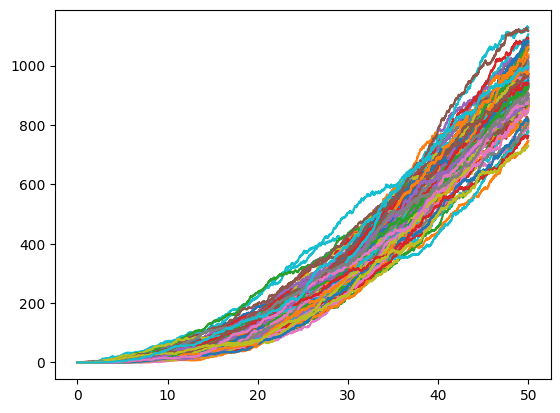

In [142]:
def fixVCML(fname):
    xmlStr=''
    with open(fname,'r') as f:
        xmlStr=''.join(list(f))
    xmlStr=re.sub(' xmlns="[^"]+"', '', xmlStr, count=1)
    tree=ET.fromstring(xmlStr)

    return tree
def parseModel(model_xml):
    compounds=odict()
    assoc_v=odict()
    rxns=[]
    stoich=[]
    for child in model_xml:
        if child.tag=='LocalizedCompound':
            compounds[child.attrib['Name']]=0
            assoc_v[child.attrib['Name']]=child.attrib['Structure']
    return compounds, assoc_v
def parseCompartmentJumps(compartment_xml,compounds):
    rxn_jump=odict()#keyed to reaction names:jump vector
    rxn_stoich=odict()
    compound_list=list(compounds.keys())
    for c in compartment_xml:
        if c.tag=='JumpProcess':
            rxn_jump[c.attrib['Name']]=np.zeros(len(compounds))
            rxn_stoich[c.attrib['Name']]=np.zeros(len(compounds))
            for i in c:
                potentialHidden=[]
                if i.tag=='Effect':
                    idx=list(compounds.keys()).index(i.attrib['VarName'].replace('_Count',''))
                    coeff=int(float(i.text))
                    if coeff==0:
                        potentialHidden.append(idx)
                    elif coeff<0:
                        rxn_stoich[c.attrib['Name']][idx]=-coeff
                    rxn_jump[c.attrib['Name']][idx]=coeff
                if not (rxn_jump[c.attrib['Name']]<0).any():
                    for idx in potentialHidden:
                        rxn_stoich[c.attrib['Name']][idx]=1
    return rxn_jump,rxn_stoich



def adjust_constants(rates, stoichs, rxn_assoc_v,override_v=5000):
    #assumes rates are in uM if there is more than one
    kmole=0.0016605387#represents 1/(s*molecules) i think
    #molecules = 10^-6 * C uM * 10^-15 * V um^3 *6.022*10^23 = C * 6.022*10^2 * V
    #k [=] 1/(s*uM^(order-1))=>1/(s*(molecules)^(order-1))
    #k in uM * uM 1/(s* 6.022*10^2 * V)
    orders=stoichs.sum(-1)
    return rates * 1/((6.022*100*rxn_assoc_v)**(orders-1))
def parseVCML(fname,custom_rates={},custom_compounds={}):
    root=fixVCML(fname)
    constants = odict()#keyed to names
    compounds=odict() #keyed to compound names:concentration
    rxn_stoichs=odict()#keyed to reaction names:stoich vector
    rate_constants=odict()#keyed to reaction names
    compartments=odict()#keyed to compartment names
    rxn_jumps=odict()
    compound_assoc_v=odict()#volumes of the compartments each compound is in, 1d
    rxn_assoc_v=odict()#volumes that each reaction takes place, 1d
    rxn_ks=0
    print(list(root[0]))
    for child in root[0]:
        name=child.tag
        if child.tag=='Model':
            compounds,compound_assoc_v=parseModel(child)#compound assoc_v is just names for rn
        elif child.tag=='SimulationSpec':
            print(child.attrib)
            if child.attrib['Stochastic']=='true':
                for child2 in child:
                    if child2.tag=='MathDescription':
                        for c in child2:
                            if c.tag=='Constant':
                                try:
                                    constants[c.attrib['Name']]=float(c.text)
                                except ValueError as ve:
                                    print(c.text,c.attrib['Name'],ve)
                                    pass
                            elif c.tag=='CompartmentSubDomain':
                                rxn_jumps,rxn_stoichs=parseCompartmentJumps(c,compounds)
                                #print(rxn_jumps)
                                rxn_ks=[constants[f"Kr_{i[:-8]}"] if 'reverse' in i else constants[f'Kf_{i}'] for i in rxn_jumps]
            if len(constants)>0:
                for v in compound_assoc_v:
                    name=compound_assoc_v[v]
                    #print(constants)
                    compound_assoc_v[v]=constants['Size_'+name]
                break


    for name in compounds: #fills conc arr with number of molecules
        #compounds[name]=np.round(constants[name+'_Count_init_uM']*compound_assoc_v[name]*6.022*100)
        compounds[name]=constants[name+'_Count_initCount']
    
    #rxn_ks['Kr__3OC6HSLdiffusion']*=compound_assoc_v['_3OC6HSL_inside']/compound_assoc_v['_3OC6HSL_out']#idk why its like this but yeah
    compound_names=list(compounds.keys())
    rxn_names=list(rxn_stoichs)
    constant_names=list(constants)
    for r in custom_rates:
        assert r in rxn_names, f"error finding {r}, doesnt match {list(rxn_names)}"
        rxn_ks[rxn_names.index(r)]=custom_rates[r]
    for c in custom_compounds:
        assert c in compounds
        compounds[c]=custom_compounds[c]
    #rxn_ks[3]*=constants['Size_Environment']/constants['Size_Cell']
    conc_arr=np.array(list(compounds.values()))
    jump_arr=np.array([rxn_jumps[i] for i in rxn_jumps])
    stoich_arr=np.array(list(rxn_stoichs.values()))
    rate_arr=np.array(rxn_ks)
    v_arr=np.array(list(compound_assoc_v.values()))
    for r in rxn_stoichs:
        idx=np.where(rxn_stoichs[r]>0)[0][0]
        #print(np.where(rxn_stoichs[r]>0))
        rxn_assoc_v[r]=compound_assoc_v[compound_names[idx]]
    rxn_v_arr=np.array(list(rxn_assoc_v.values()))
    adjusted=adjust_constants(rxn_ks,stoich_arr,rxn_v_arr)
    for i in range(len(rxn_ks)):
        print(adjusted[i],list(rxn_stoichs)[i],i)
    
    return compounds,jump_arr,stoich_arr,adjusted,v_arr,rxn_v_arr

detectCompounds,detectChanges,detectStoichs,detectRates,d_v,d_rv=parseVCML('SF_detector.vcml',custom_rates={"a_diffuse_reverse":100,'s_diffuse_reverse':100})
for idx,c in enumerate(detectCompounds):
    print(idx,c,detectCompounds[c])
detectCompound_arr=np.array(list(detectCompounds.values()))

[<Element 'Model' at 0x15f6ee1d0>, <Element 'SimulationSpec' at 0x15f6ae810>, <Element 'Version' at 0x15f6af8b0>, <Element 'pathwayModel' at 0x15f6af9a0>, <Element 'relationshipModel' at 0x15f6afb80>, <Element 'vcmetadata' at 0x15f6afc20>]
{'Name': 'Application0', 'Stochastic': 'true', 'UseConcentration': 'false', 'RandomizeInitCondition': 'false', 'RuleBased': 'false', 'MassConservationModelReduction': 'false', 'InsufficientIterations': 'false', 'InsufficientMaxMolecules': 'false'}
(1.0 * pow(KMOLE, - 1.0)) UnitFactor_molecules_uM_neg_1_um_neg_3 could not convert string to float: '(1.0 * pow(KMOLE, - 1.0))'
(1.0 * pow(KMOLE,1.0)) UnitFactor_uM_um3_molecules_neg_1 could not convert string to float: '(1.0 * pow(KMOLE,1.0))'
1.0 a_diffuse 0
100.0 a_diffuse_reverse 1
0.009996678844237793 analyte_bind 2
1.0 analyte_bind_reverse 3
1.0 signal_transcribe 4
0.0 signal_transcribe_reverse 5
0.009996678844237793 signal_bind 6
1.0 signal_bind_reverse 7
1.0 signal_translate 8
0.0 signal_translate_r

In [163]:
ts1_50_detect,concs1_50_detect=makeReplicate(1,detectCompound_arr,detectChanges,detectStoichs,detectRates,np.array([0,1]),
                              .01,0,50,1)#1 cell is 124s 50 sec sim
ts10_50_detect,concs10_50_detect=makeReplicate(10,detectCompound_arr,detectChanges,detectStoichs,detectRates,np.array([0,1]),
                              .01,0,50,1)#10 cells is 4 minutes 20 sec sim, 10 cells 50 sec is 1007 s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:04<00:00, 124.88s/it]


done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [2:47:56<00:00, 10076.37s/it]

done


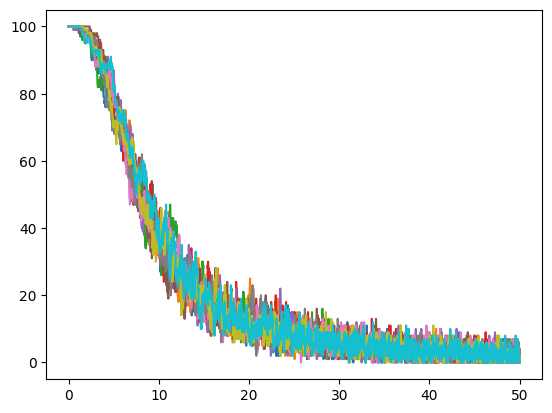

In [192]:
plt.plot(ts10_50_detect,concs10_50_detect[0,:,:,4].T)
plt.show()

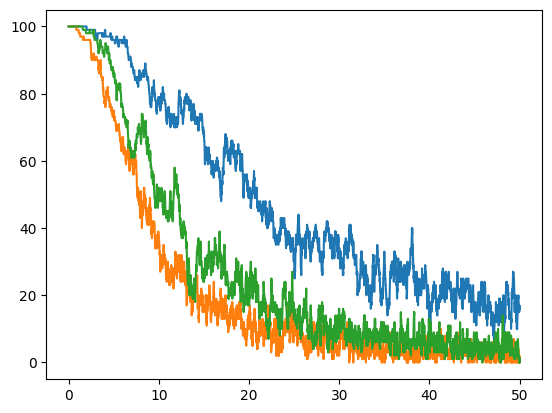

In [198]:
plt.plot(ts1_50_detect,concs1_50_detect[0,:,:,4].T)
plt.plot(ts10_50_detect,concs10_50_detect[0,0,:,4].T)
plt.plot(ts10_50_detect,concs5_50_detect[0,0,:,4].T)
plt.show()

In [172]:
print(concs10_50_detect[:,:,-1,10].mean(0).mean(0))
print(concs10_50_detect[:,:,-1,10].sum(1).mean(0))
print(concs10_50_detect[:,:,2000,10].mean(0).mean(0))
print(concs10_50_detect[:,:,2000,10].sum(1).mean(0))
print('one cell:')
print(concs1_50_detect[:,:,-1,10].mean(0).mean(0))
print(concs1_50_detect[:,:,-1,10].sum(1).mean(0))
print(concs1_50_detect[:,:,2000,10].mean(0).mean(0))
print(concs1_50_detect[:,:,2000,10].sum(1).mean(0))

61366.6
613666.0
6366.4
63664.0
one cell:
33615.0
33615.0
2111.0
2111.0


In [170]:
np.argwhere(ts10_50_detect==20)

array([[2000]])

In [194]:
ts5_50_detect,concs5_50_detect=makeReplicate(5,detectCompound_arr,detectChanges,detectStoichs,detectRates,np.array([0,1]),
                              .01,0,50,1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [1:03:23<00:00, 3803.87s/it]

done


In [196]:
concs5_50_detect.tofile('concs5_50_detect')

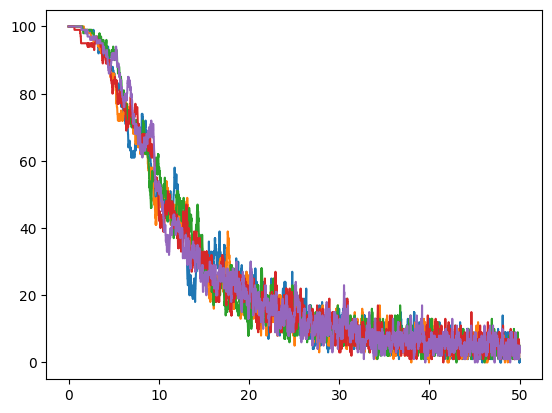

In [197]:
plt.plot(ts10_50_detect,concs5_50_detect[0,:,:,4].T)
plt.show()

In [201]:
concs1_50_detect[0,:,-1,10].mean(),concs5_50_detect[0,:,-1,10].mean(),concs10_50_detect[0,:,-1,10].mean()


(33615.0, 54091.0, 61366.6)

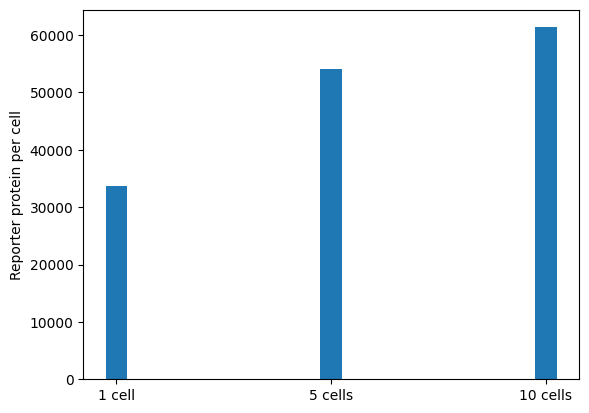

In [206]:
fig,ax=plt.subplots()
ax.bar(['1 cell','5 cells','10 cells'],[33615.0, 54091.0, 61366.6],width=0.1)
ax.set_ylabel('Reporter protein per cell')
plt.show()

In [ ]:
def doAnalysis(ts,cell_concs,idx=-1):
    #plt.plot(ts,cell_concs[:,:,:,idx].mean(0).T,alpha=0.4,color='gray')
    plt.plot(ts,cell_concs[:,:,:,idx].mean(0).T)
    #plt.plot(ts,cell_concs[:,:,:,idx].mean(0).mean(0).T)
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count Per Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.vlines(20,0,cell_concs[:,:,:,idx].mean(0).T.max(),linestyles='dashed')
    plt.show()
    plt.plot(ts,cell_concs[0,:,:,idx].T)
    plt.vlines(20,0,cell_concs[0,:,:,idx].T.max(),linestyles='dashed')
    plt.xlabel("Time (s)")
    plt.title("Reporter Protein Count In a Single Cell as a Function of Time")
    plt.ylabel("Reporter Protein Count")
    plt.show()
    print('mean overall P concentration')
    print(cell_concs[:,:,-1,idx].mean())
    print('aggregate overall P concentration')
    print(cell_concs[:,:,-1,idx].mean(0).sum())
    print('mean concentrations per trial')
    printVert(cell_concs[:,:,-1,idx].mean(1))
    print('mean aggregate P production')
    printVert(cell_concs[:,:,-1,idx].sum(1))
    return 
doAnalysis(ts50_50s,cell_concs1_50s)

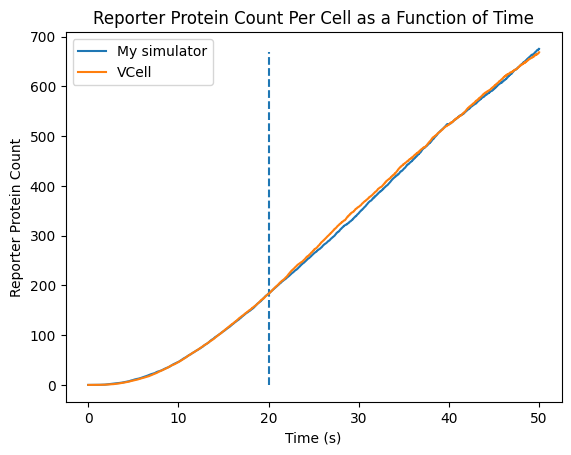

r^2: 0.9993157916447529


In [229]:
importedVcell=np.loadtxt("vcell_1cell_50s.tsv",delimiter='\t').reshape(-1,2)
fig_vcell,ax_vcell=plt.subplots()
ax_vcell.set_xlabel("Time (s)")
ax_vcell.set_title("Reporter Protein Count Per Cell as a Function of Time")
ax_vcell.set_ylabel("Reporter Protein Count")
ax_vcell.vlines(20,0,importedVcell[1:,1].max(),linestyles='dashed')
ax_vcell.plot(ts1_50s,cell_concs1_50s[:,0,:,-1].mean(0),label="My simulator")
ax_vcell.plot(importedVcell[1:,0],importedVcell[1:,1],label="VCell")
ax_vcell.legend()
plt.show()
print('r^2:',r2_score(importedVcell[2:,1],cell_concs1_50s[:,0,:,-1].mean(0)))

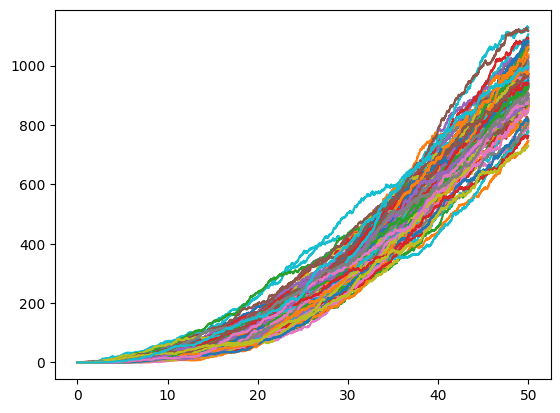

In [234]:
'''
[tf_out,tf,dna,tf.dna,mrna_tf,null,P]
'''
plt.plot(ts100_50s,cell_concs100_50s[0,:,:,-1].T)
plt.show()

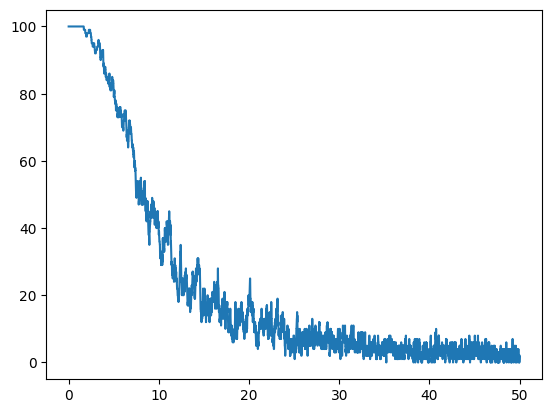

In [241]:
'''
0 analyte 10000.0
1 signal 0.0
2 analyte_inside 0.0
3 signal_inside 0.0
4 signal_operon 100.0
5 signal_mrna 0.0
6 analyte_operon 100.0
7 bound_analyte 0.0
8 bound_signal 0.0
9 reporter_mrna 0.0
10 reporter 0.0
11 degraded 0.0
'''
plt.plot(ts10_50_detect,concs10_50_detect[0,1,:,4].T)
plt.show()

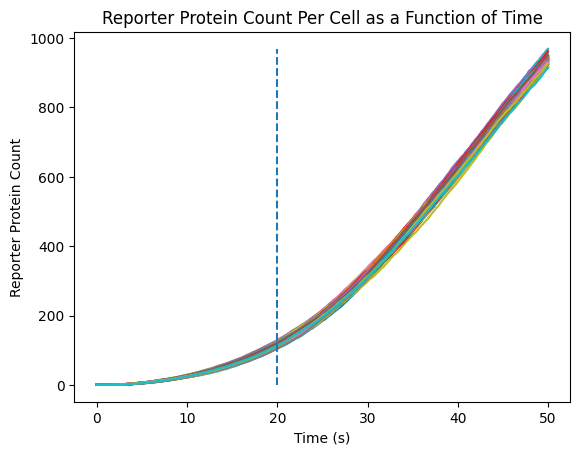

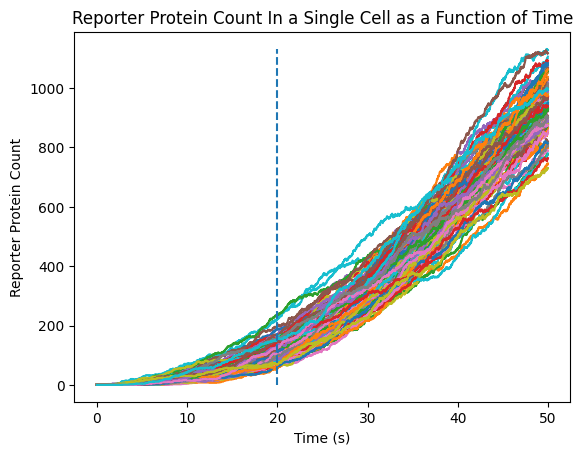

mean overall P concentration
935.995
aggregate overall P concentration
93599.5
mean concentrations per trial
930.56
916.96
914.99
946.04
943.06
911.51
938.16
936.12
927.24
919.11
919.11
919.54
919.73
951.37
920.59
929.37
928.81
961.88
921.21
937.87
940.16
960.98
930.97
931.41
951.19
954.4
952.84
925.83
970.16
982.32
944.55
917.43
944.88
937.19
955.44
942.94
942.04
927.37
941.69
947.17
931.07
944.76
936.88
915.93
924.0
917.2
939.68
938.4
925.93
931.71
mean aggregate P production
93056.0
91696.0
91499.0
94604.0
94306.0
91151.0
93816.0
93612.0
92724.0
91911.0
91911.0
91954.0
91973.0
95137.0
92059.0
92937.0
92881.0
96188.0
92121.0
93787.0
94016.0
96098.0
93097.0
93141.0
95119.0
95440.0
95284.0
92583.0
97016.0
98232.0
94455.0
91743.0
94488.0
93719.0
95544.0
94294.0
94204.0
92737.0
94169.0
94717.0
93107.0
94476.0
93688.0
91593.0
92400.0
91720.0
93968.0
93840.0
92593.0
93171.0


In [248]:
doAnalysis(ts10_50s,cell_concs100_50s)